In [79]:
# load what we need
library(dplyr)
library(reshape2)
library(dunn.test)
library(ggplot2)

In [11]:
survey_data <- read.csv("survey_response_data.csv")
str(survey_data)

'data.frame':	331 obs. of  26 variables:
 $ StartDate                        : chr  "5/15/20 9:07" "5/15/20 11:53" "5/15/20 13:08" "5/15/20 13:41" ...
 $ Country                          : chr  "Germany" "USA" "Germany" "USA" ...
 $ HiveNumber                       : chr  "2" "7" "14" "2" ...
 $ Experience                       : chr  "Less than 1" "Between 1 and 3" "Between 5 and 10" "Between 3 and 5" ...
 $ Training                         : chr  "General hive management" "I haven't used educational programmes" "I haven't used educational programmes" "Disease management,Making a business of beekeeping,Queen rearing,General hive management" ...
 $ Threat_rank.CC                   : int  1 7 5 5 3 5 4 3 7 7 ...
 $ Threat_rank.Nosema               : int  6 3 6 6 7 7 5 5 4 5 ...
 $ Threat_rank.Other.disease.or.pest: int  5 2 2 2 4 2 3 4 2 2 ...
 $ Threat_rank.Flowerdecline        : int  3 5 3 4 5 4 6 2 1 3 ...
 $ Threat_rank.Pesticides           : int  NA NA NA NA NA NA NA NA NA NA ...
 

In [12]:
head(survey_data) 

,StartDate,Country,HiveNumber,Experience,Training,Threat_rank.CC,Threat_rank.Nosema,Threat_rank.Other.disease.or.pest,Threat_rank.Flowerdecline,Threat_rank.Pesticides,⋯,If.WhenSugar,SugarWeeks,HowMuchSugar,Pest_rank.Nosema,Pest_rank.Varroa,Pest.rank.Foulbrood,Pest_rank.DWV,Pest_rank.Chalkbrood,Pest_rank.SHB,Colonyloss5
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,5/15/20 9:07,Germany,2,Less than 1,General hive management,1,6,5,3,NA,⋯,"Autumn,Winter",2+ to 4,501-1000g,3,7,4,3,3,NA,NA
2,5/15/20 11:53,USA,7,Between 1 and 3,I haven't used educational programmes,7,3,2,5,NA,⋯,Winter,8+ to 10,251-500g,4,10,5,7,5,NA,30
3,5/15/20 13:08,Germany,14,Between 5 and 10,I haven't used educational programmes,5,6,2,3,NA,⋯,Autumn,0 to 2,1500g+,1,8,3,5,5,NA,10
4,5/15/20 13:41,USA,2,Between 3 and 5,"Disease management,Making a business of beekeeping,Queen rearing,General hive management",5,6,2,4,NA,⋯,Winter,6+ to 8,0-250g,4,9,8,8,4,NA,22
5,5/15/20 14:01,Canada,3,Between 5 and 10,"Disease management,Chemical treatments,General hive management,Other",3,7,4,5,NA,⋯,Autumn,2+ to 4,251-500g,1,5,1,1,4,NA,40
6,5/15/20 15:18,USA,3,Between 1 and 3,"Making a business of beekeeping,Food supplementation,Queen rearing,General hive management",5,7,2,4,NA,⋯,"Autumn,Winter,Spring",8+ to 10,501-1000g,3,9,4,3,4,NA,100


## 1. Analysing the biggest perceived threats in each region 

In [13]:
group_by(survey_data, If.WhenPollen) %>% summarise(count = n())

If.WhenPollen,count
<chr>,<int>
,1
Autumn,5
"Autumn,Spring",7
"Autumn,Spring,Summer",3
"Autumn,Summer",1
"Autumn,Winter",2
"Autumn,Winter,Spring",2
"Autumn,Winter,Summer",1
I don't supplement pollen,222


In [15]:
group_by(survey_data, If.WhenSugar) %>% summarise(count = n())

If.WhenSugar,count
<chr>,<int>
,6
Autumn,52
"Autumn,Spring",37
"Autumn,Summer",1
"Autumn,Summer,Spring",4
"Autumn,Winter",54
"Autumn,Winter,Spring",35
"Autumn,Winter,Summer",6
"Autumn,Winter,Summer,Spring",7


In [16]:
group_by(survey_data, Experience) %>% summarise(count = n())

Experience,count
<chr>,<int>
15+,51
Between 1 and 3,70
Between 10 and 15,50
Between 3 and 5,70
Between 5 and 10,76
Less than 1,14


In [17]:
mean(survey_data$Colonyloss5, na.rm=TRUE)
sd(survey_data$Colonyloss5,na.rm=TRUE)
median(survey_data$Colonyloss5,na.rm=TRUE)
IQR(survey_data$Colonyloss5,na.rm=TRUE)

[1] 17.23411

[1] 20.16938

[1] 10

[1] 19

In [18]:
# mostly UK and then next highest is US. Not enough of the other countries to make a sample so i want to group
# them together as "other"
survey_data$Country <- ifelse(survey_data$Country == "USA","USA", ifelse(survey_data$Country == "UK", "UK", "Other"))
Threats <- subset(survey_data, select = c(Country, Threat_rank.CC, Threat_rank.Nosema, Threat_rank.Other.disease.or.pest, Threat_rank.Flowerdecline, Threat_rank.Pesticides, Threat_rank.LandUseChannge, Threat_rank.AsianHornet, Threat_rank.Varroa))
head(Threats)

,Country,Threat_rank.CC,Threat_rank.Nosema,Threat_rank.Other.disease.or.pest,Threat_rank.Flowerdecline,Threat_rank.Pesticides,Threat_rank.LandUseChannge,Threat_rank.AsianHornet,Threat_rank.Varroa
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Other,1,6,5,3,NA,2,7,4
2,USA,7,3,2,5,NA,4,6,1
3,Other,5,6,2,3,NA,4,7,1
4,USA,5,6,2,4,NA,3,7,1
5,Other,3,7,4,5,NA,2,6,1
6,USA,5,7,2,4,NA,6,3,1


In [19]:
group_by(survey_data, Country) %>% summarise(count = n())

Country,count
<chr>,<int>
Other,24
UK,266
USA,41


In [23]:
# to plot in a barchart i will need all the different threats under 1 "Threat Type" column
colnames(Threats) <- c("Country", "Climate Change", "Nosema", "Other Pest", "Flower Decline", "Pesticides", "Land Use Change", "Asian Hornet", "Varroa")
Threats1 <- melt(Threats, id.vars = "Country", measure.vars = c("Climate Change", "Nosema", "Other Pest", "Flower Decline", "Pesticides", "Land Use Change", "Asian Hornet", "Varroa"),
                 variable.name = "Threat", na.rm = TRUE, value.name = "Rank")

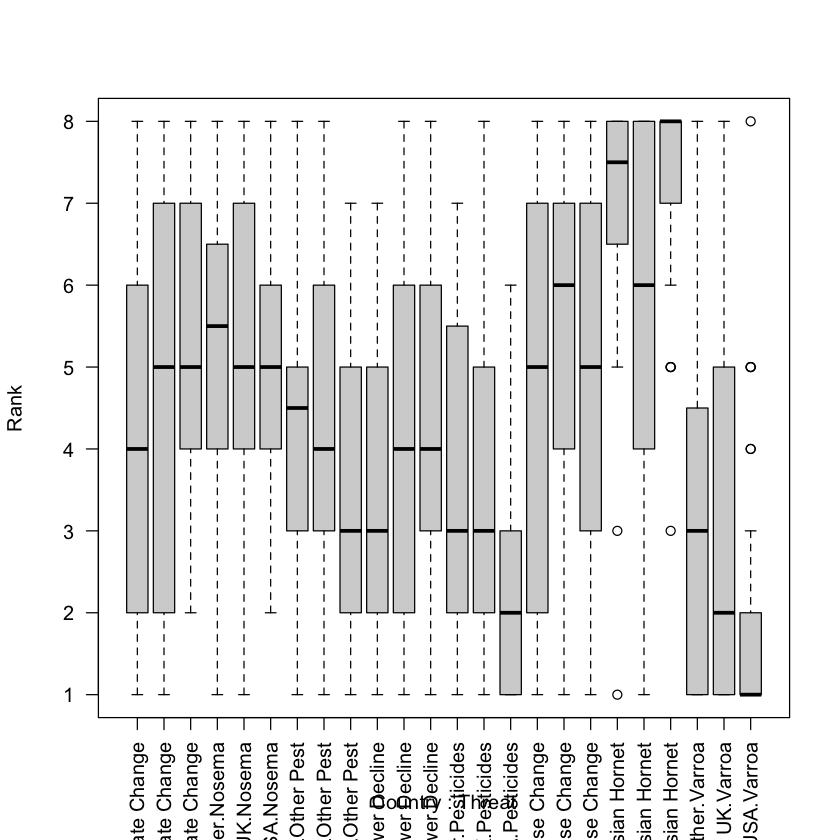

In [24]:
# Lets have a look on a boxplot to see what they each seem to show
boxplot(Rank ~ Country*Threat, data = Threats1, las = 2)
# because of the ranking, nearly all groups have the same rank and similar IQRs, but medians are different

In [25]:
# will run a Kruskal-Wallace to see if they are significant
# initial test will be for all countries grouped
kruskal.test(Rank ~ Threat, data = Threats1, na.action = na.omit)
# highly significant, so we can be confident that there are significant differences in medians of gorups


	Kruskal-Wallis rank sum test

data:  Rank by Threat
Kruskal-Wallis chi-squared = 404.65, df = 7, p-value < 2.2e-16


In [27]:
# will run pairwise tests to see whether nosema is significantly different from others - will use Dunn's test, typical for 
# Kruskall-Wallace like this
dunn.test(Threats1$Rank, Threats1$Threat, method = "bh", kw=TRUE, label = TRUE, wrap = TRUE, alpha = 0.05, altp = TRUE)
# nosema signif higher than asian hornet
# nosema signif lower than climate change, flower decline, other pests, pesticides, varroa
# non-signif from land use change
# so people rank nosema far lower than lots of other factors

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 404.6458, df = 7, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Asian Ho   Climate    Flower D   Land Use     Nosema   Other Pe   Pesticid
---------+-----------------------------------------------------------------------------
Climate  |   5.980086
         |    0.0000*
         |
Flower D |   9.565466   3.585379
         |    0.0000*    0.0005*
         |
Land Use |   1.930862  -4.049224  -7.634603
         |     0.0599    0.0001*    0.0000*
         |
  Nosema |   3.060030  -2.920055  -6.505435   1.129168
         |    0.0028*    0.0043*    0.0000*     0.2588
         |
Other Pe |   7.744869   1.764782  -1.820597   5.814006   4.684838
         |    0.0000*     0.0805     0.0740    0.0000*    0.0000*
         |
Pesticid |   12.23543   6.315546   2.766257   1

In [28]:
# lets have a look at each region separately 
ThreatsUK <- Threats1 %>% subset(Country=="UK")
kruskal.test(Rank ~ Threat, data = ThreatsUK, na.action = na.omit)
dunn.test(ThreatsUK$Rank, ThreatsUK$Threat, method = "bh", kw=TRUE, label = TRUE, wrap = TRUE, alpha = 0.05, altp = TRUE)
# nosema signif lower climate change, flower decline, other pests, pesticides and varroa
# non-signif diff with asian hornet and land use which shows in the barchart


	Kruskal-Wallis rank sum test

data:  Rank by Threat
Kruskal-Wallis chi-squared = 268.68, df = 7, p-value < 2.2e-16


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 268.6803, df = 7, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Asian Ho   Climate    Flower D   Land Use     Nosema   Other Pe   Pesticid
---------+-----------------------------------------------------------------------------
Climate  |   3.897900
         |    0.0002*
         |
Flower D |   6.868339   2.970438
         |    0.0000*    0.0040*
         |
Land Use |  -0.681419  -4.579319  -7.549758
         |     0.4956    0.0000*    0.0000*
         |
  Nosema |   1.247572  -2.650327  -5.620766   1.928992
         |     0.2285    0.0102*    0.0000*     0.0627
         |
Other Pe |   4.729983   0.832082  -2.138355   5.411402   3.482410
         |    0.0000*     0.4204    0.0396*    0.0000*    0.0007*
         |
Pesticid |   8.720969   4.826740   1.859100   9

In [29]:
ThreatsUSA <- Threats1 %>% subset(Country=="USA")
kruskal.test(Rank ~ Threat, data = ThreatsUSA)
dunn.test(ThreatsUSA$Rank, ThreatsUSA$Threat, method = "bh", kw=TRUE, label = TRUE, wrap = TRUE, alpha = 0.05, altp = TRUE)
# nosema signif higher than asian hornet
# non-signif diff with climate change and land use change
# signif lower than flower decline, other pests, pesticides, varroa


	Kruskal-Wallis rank sum test

data:  Rank by Threat
Kruskal-Wallis chi-squared = 157.65, df = 7, p-value < 2.2e-16


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 157.6463, df = 7, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Asian Ho   Climate    Flower D   Land Use     Nosema   Other Pe   Pesticid
---------+-----------------------------------------------------------------------------
Climate  |   3.746583
         |    0.0004*
         |
Flower D |   6.006083   2.259500
         |    0.0000*    0.0318*
         |
Land Use |   4.674205   0.927622  -1.331877
         |    0.0000*     0.3667     0.2227
         |
  Nosema |   3.697254  -0.049328  -2.308828  -0.976951
         |    0.0004*     0.9607    0.0293*     0.3539
         |
Other Pe |   7.283819   3.537236   1.277736   2.609614   3.586565
         |    0.0000*    0.0007*     0.2349    0.0134*    0.0006*
         |
Pesticid |   8.876398   5.338124   3.204251   4

In [30]:
ThreatsOther <- Threats1 %>% subset(Country=="Other")
kruskal.test(Rank ~ Threat, data = ThreatsOther)
dunn.test(ThreatsOther$Rank, ThreatsOther$Threat, method = "bh", kw=TRUE, label = TRUE, wrap = TRUE, alpha = 0.05, altp = TRUE)
# nosema signif higher than asian hornet
# non-signif with climate change, land use change, other pests
# signif higher than flower decline, pesticdes and varroa
# but only 26 reps from all over the world so hard to mke much of this data


	Kruskal-Wallis rank sum test

data:  Rank by Threat
Kruskal-Wallis chi-squared = 43.904, df = 7, p-value = 2.23e-07


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 43.9041, df = 7, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Asian Ho   Climate    Flower D   Land Use     Nosema   Other Pe   Pesticid
---------+-----------------------------------------------------------------------------
Climate  |   4.309929
         |    0.0001*
         |
Flower D |   4.812576   0.502646
         |    0.0000*     0.6890
         |
Land Use |   3.342066  -0.967862  -1.470509
         |    0.0039*     0.4664     0.2475
         |
  Nosema |   2.390246  -1.919683  -2.422330  -0.951820
         |    0.0471*     0.1182    0.0480*     0.4549
         |
Other Pe |   3.534569  -0.775359  -1.278006   0.192503   1.144323
         |    0.0023*     0.5334     0.3315     0.8473     0.3721
         |
Pesticid |   4.918991   0.809634   0.330380   1.

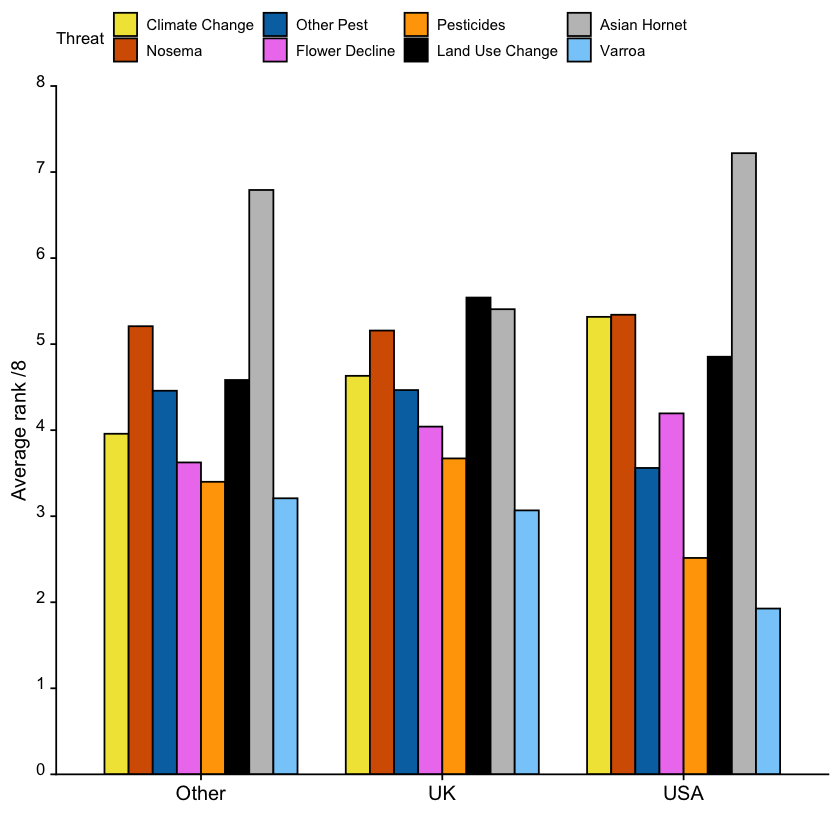

In [33]:
# now lets plot it
threatsplot1 <- ggplot(Threats1, aes(Country, Rank)) + geom_bar(aes(fill = Threat), position = position_dodge(0.8),width = 0.8, stat = "summary", fun = "mean", colour = "black") + 
scale_fill_manual(values =  c("#F0E442", "#D55E00","#0072B2", "#EE82EE","#FFA500","#000000","#C0C0C0","#87CEFA")) + theme_cowplot() + ylab("Average rank /8") + xlab("") + scale_x_discrete(labels = c("Other", "UK", "USA")) + theme(axis.text.x = element_text(face = "plain",size = 12,vjust = 0.99, hjust = 0.5, colour = "black"), axis.text.y = element_text(face="plain", size = 10, angle = 0, vjust = 0.0,  hjust = 0.5, colour = "black"))+ theme(text = element_text(size=12)) + scale_y_continuous(limits = c(0,8), expand = c(0,0), breaks = seq(0,8, by = 1)) + guides(fill=guide_legend(title="Threat")) + theme(legend.text=element_text(size=9), legend.title=element_text(size=10), legend.position = "top")
threatsplot1
# With 8 threats, the amount of info on the graph is a lot so don't think I will put in results
# however, asian hornet is always pretty low, varroa always high, and nosema is always 2nd or 3rd bottom
# doesnt seem as though people consider nosema a major threat

## 2. Analysing and plotting the highest ranked diseases in each region

In [34]:
# create a df with just country and diseases
Diseases <- subset(survey_data, select = c(Country, Pest_rank.Nosema, Pest_rank.Varroa, Pest.rank.Foulbrood, Pest_rank.DWV, Pest_rank.Chalkbrood, Pest_rank.SHB))
colnames(Diseases) <- c("Country", "Nosema", "Varroa", "Foulbrood", "DWV", "Chalkbrood", "SHB")
Diseases1 <- melt(Diseases, id.vars = "Country", measure.vars = c("Nosema", "Varroa", "Foulbrood", "DWV", "Chalkbrood", "SHB"),
                 variable.name = "Disease", na.rm = TRUE, value.name = "Rating")
Diseases1

,Country,Disease,Rating
,<chr>,<fct>,<int>
1,Other,Nosema,3
2,USA,Nosema,4
3,Other,Nosema,1
4,USA,Nosema,4
5,Other,Nosema,1
6,USA,Nosema,3
7,USA,Nosema,1
8,Other,Nosema,2
9,USA,Nosema,1


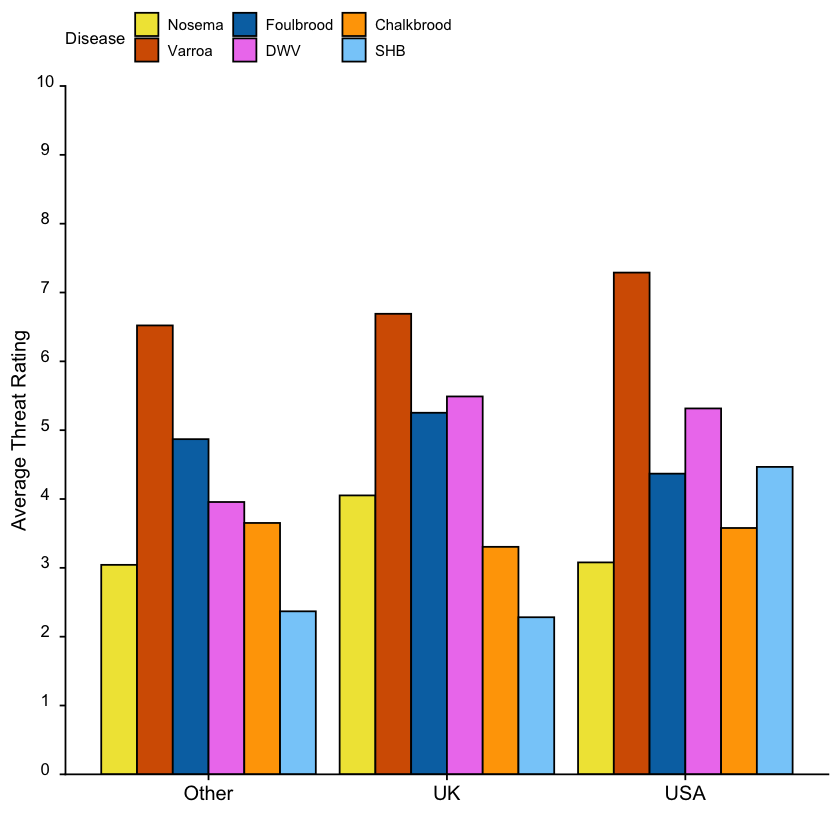

In [36]:
# plot the data and see what were dealing with 
Diseasesplot1 <- ggplot(Diseases1, aes(Country, Rating)) + geom_bar(aes(fill = Disease), position = "dodge", stat = "summary", fun = "mean", colour = "black") + 
scale_fill_manual(values =  c("#F0E442", "#D55E00","#0072B2", "#EE82EE","#FFA500","#87CEFA")) + theme_cowplot() + ylab("Average Threat Rating") + 
xlab("") + scale_x_discrete(labels = c("Other", "UK", "USA")) + theme(axis.text.x = element_text(face = "plain",size = 12,vjust = 0.99, hjust = 0.5, colour = "black"), axis.text.y = element_text(face="plain", size = 10, angle = 0, vjust = 0.0,  hjust = 0.5, colour = "black")) + 
theme(text = element_text(size=12)) + scale_y_continuous(limits = c(0,10), expand = c(0,0), breaks = seq(0,10, by = 1)) + guides(fill=guide_legend(title="Disease")) + theme(legend.text=element_text(size=9), legend.title=element_text(size=10), legend.position = "top")
Diseasesplot1
# nosema is the lowest concern in US and 3 lowest in the UK and 2nd lowest in Other countries

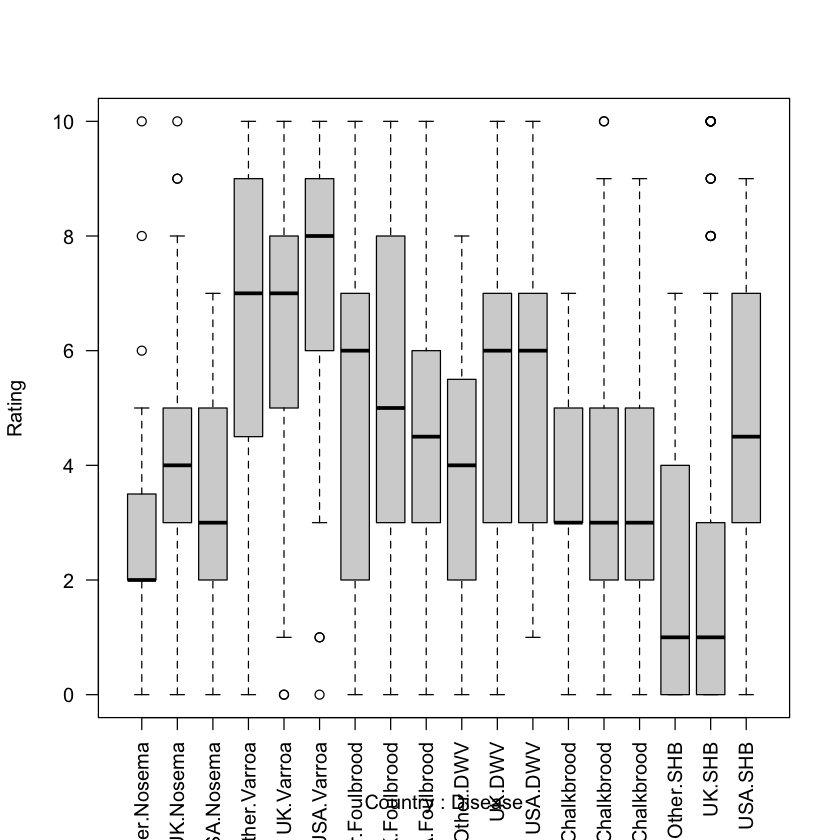

In [37]:
# see a boxplot to look at potential differences in medians to look out for
boxplot(Rating ~ Country*Disease, data = Diseases1, las = 2)
# because scale is 1-10, they all have basically the same range
# but there are differences in medians, both within and between regions

In [39]:
# UK
diseaseUK <- subset(Diseases1, Country=="UK")
kruskal.test(Rating ~ Disease, data = diseaseUK)
dunn.test(diseaseUK$Rating, diseaseUK$Disease, method = "bh", kw=TRUE, label = TRUE, wrap = TRUE, alpha = 0.05, altp = TRUE)
# nosema signif higher than chalkbrood and SHB
# signif lower than DWV, Foulbrood and Varroa


	Kruskal-Wallis rank sum test

data:  Rating by Disease
Kruskal-Wallis chi-squared = 406.9, df = 5, p-value < 2.2e-16


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 406.9015, df = 5, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Chalkbro        DWV   Foulbroo     Nosema        SHB
---------+-------------------------------------------------------
     DWV |  -8.915132
         |    0.0000*
         |
Foulbroo |  -7.377689   1.537443
         |    0.0000*     0.1242
         |
  Nosema |  -3.212401   5.702730   4.165287
         |    0.0014*    0.0000*    0.0000*
         |
     SHB |   4.316677   13.22283   11.68694   7.525845
         |    0.0000*    0.0000*    0.0000*    0.0000*
         |
  Varroa |  -13.25399  -4.338867  -5.876310  -10.04159  -17.55733
         |    0.0000*    0.0000*    0.0000*    0.0000*    0.0000*

alpha = 0.05
Reject Ho if p <= alpha


In [40]:
# US
diseaseUSA <- subset(Diseases1, Country=="USA")
kruskal.test(Rating ~ Disease, data = diseaseUSA)
# highly signif
dunn.test(diseaseUSA$Rating, diseaseUSA$Disease, method = "bh", kw=TRUE, label = TRUE, wrap = TRUE, alpha = 0.05, altp = TRUE)
# nosema non-signif diff with chalkbrood
# significantly lower than DWV, Foulbrood, SHB and Varroa


	Kruskal-Wallis rank sum test

data:  Rating by Disease
Kruskal-Wallis chi-squared = 55.151, df = 5, p-value = 1.216e-10


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 55.1505, df = 5, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Chalkbro        DWV   Foulbroo     Nosema        SHB
---------+-------------------------------------------------------
     DWV |  -2.908741
         |    0.0091*
         |
Foulbroo |  -1.309205   1.599535
         |     0.2381     0.1646
         |
  Nosema |   0.869174   3.777915   2.178380
         |     0.4122    0.0005*    0.0490*
         |
     SHB |  -1.471650   1.260635  -0.241866  -2.288098
         |     0.1924     0.2394     0.8089    0.0415*
         |
  Varroa |  -5.762137  -2.853396  -4.452932  -6.631312  -3.940935
         |    0.0000*    0.0093*    0.0000*    0.0000*    0.0003*

alpha = 0.05
Reject Ho if p <= alpha


In [41]:
# Other
diseaseOther <- subset(Diseases1, Country=="Other")
kruskal.test(Rating ~ Disease, data = diseaseOther)
# highly signif
dunn.test(diseaseOther$Rating, diseaseOther$Disease, method = "bh", kw=TRUE, label = TRUE, wrap = TRUE, alpha = 0.05, altp = TRUE)
# non signif with all except varroa which nosema was signif lower than
# not many reps in this group and they vary all over the world so likely to have a lot variation


	Kruskal-Wallis rank sum test

data:  Rating by Disease
Kruskal-Wallis chi-squared = 27.245, df = 5, p-value = 5.11e-05


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 27.2452, df = 5, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Chalkbro        DWV   Foulbroo     Nosema        SHB
---------+-------------------------------------------------------
     DWV |  -0.330336
         |     0.7411
         |
Foulbroo |  -1.294613  -0.964276
         |     0.2932     0.4186
         |
  Nosema |   0.935634   1.265971   2.230247
         |     0.4032     0.2803     0.0643
         |
     SHB |   1.641323   1.955535   2.872746   0.751357
         |     0.1679     0.1083    0.0153*     0.4848
         |
  Varroa |  -3.072319  -2.741982  -1.777706  -4.007954  -4.563681
         |    0.0106*    0.0183*     0.1415    0.0005*    0.0001*

alpha = 0.05
Reject Ho if p <= alpha


## 3. Plotting threats

In [42]:
surveyUSUK <- subset(survey_data, subset = Country %in% c("UK", "USA"))
ThreatsUSUK <- subset(surveyUSUK, select = c(Country, Threat_rank.CC, Threat_rank.Nosema, Threat_rank.Other.disease.or.pest, Threat_rank.Flowerdecline, Threat_rank.Pesticides, Threat_rank.LandUseChannge, Threat_rank.AsianHornet, Threat_rank.Varroa))
colnames(ThreatsUSUK) <- c("Country", "Climate Change", "Nosema", "Other Pest", "Flower Decline", "Pesticides", "Land Use Change", "Asian Hornet", "Varroa")
# for easy reading it would be nice to have the bars in height order, so will change the column order so we go
# from most-least dangerous
ThreatsUSUK <- ThreatsUSUK[,c(1,9,6,5,4,2,3,7,8)]
ThreatsUSUK1 <- melt(ThreatsUSUK, id.vars = "Country", measure.vars = c("Varroa", "Pesticides", "Flower Decline", "Other Pest","Climate Change", "Nosema", "Asian Hornet", "Land Use Change"),
                 variable.name = "Threat", na.rm = TRUE, value.name = "Rank")
# and we want to create some summary information so we can add error bars too
ThreatsUSUKsum <- ThreatsUSUK1 %>% group_by(Country, Threat) %>% summarise(mean_rank = mean(Rank),sd_rank = sd(Rank), n_rank = n(), se_rank = sd(Rank)/sqrt(n()))

`summarise()` has grouped output by 'Country'. You can override using the `.groups` argument.


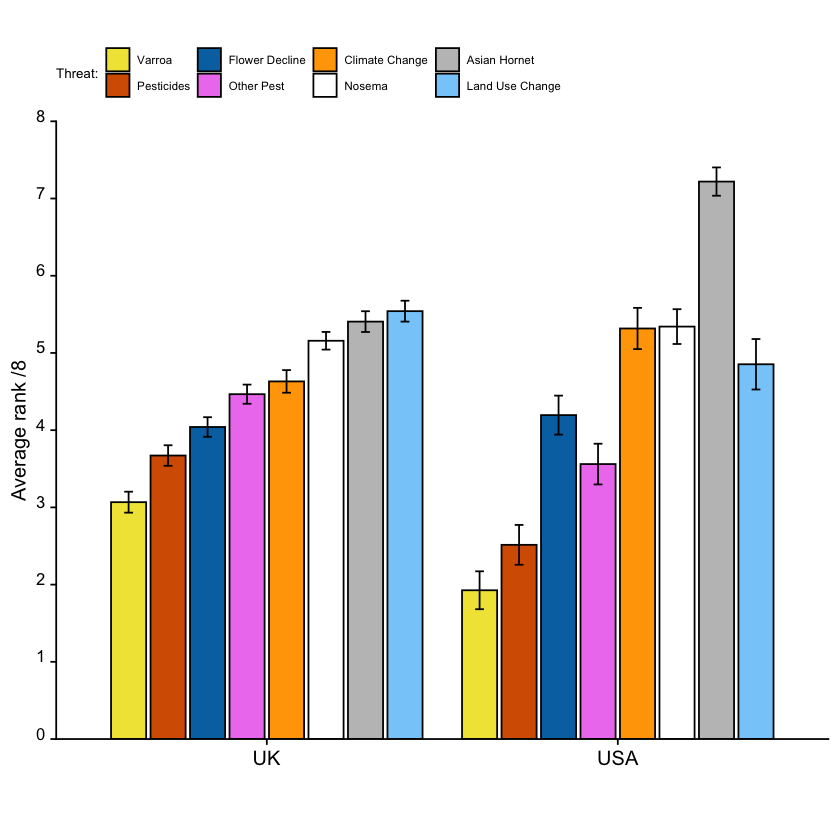

In [44]:
ThreatsUSUKplot <- ggplot(ThreatsUSUKsum, aes(x = Country, y = mean_rank, fill = Threat)) + geom_bar(position = position_dodge(0.9),width = 0.8, stat = "summary", fun = "mean", colour = "black") + 
geom_errorbar(data = ThreatsUSUKsum, aes(ymin = mean_rank-se_rank, ymax = mean_rank+se_rank), position = position_dodge(0.9), width = 0.2) + 
scale_fill_manual(values =  c("#F0E442", "#D55E00","#0072B2", "#EE82EE","#FFA500","#FFFFFF","#C0C0C0","#87CEFA")) + theme_cowplot() + ylab("Average rank /8") + xlab("") + 
scale_x_discrete(labels = c("UK", "USA")) + theme(axis.text.x = element_text(face = "plain",size = 12,vjust = 0.99, hjust = 0.5, colour = "black"), axis.text.y = element_text(face="plain", size = 10, angle = 0, vjust = 0.0,  hjust = 0.5, colour = "black")) + 
theme(text = element_text(size=12)) + scale_y_continuous(limits = c(0,8), expand = c(0,0), breaks = seq(0,8, by = 1)) + guides(fill=guide_legend(title="Threat:")) + 
theme(legend.text=element_text(size=7), legend.title=element_text(size=8), legend.position = "top") + theme(aspect.ratio = 4/5)
ThreatsUSUKplot

`summarise()` has grouped output by 'Country'. You can override using the `.groups` argument.


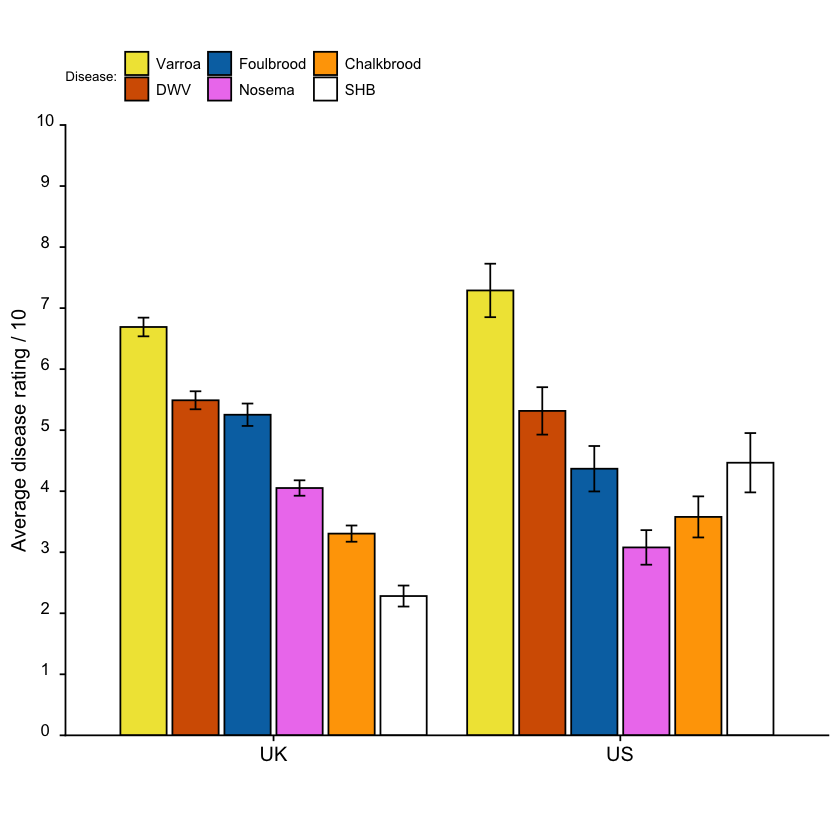

In [45]:
# now let's to do the same thing for disease too 
DiseasesUSUK <- subset(surveyUSUK, select = c(Country, Pest_rank.Nosema, Pest_rank.Varroa, Pest.rank.Foulbrood, Pest_rank.DWV, Pest_rank.Chalkbrood, Pest_rank.SHB))
colnames(DiseasesUSUK) <- c("Country", "Nosema", "Varroa", "Foulbrood", "DWV", "Chalkbrood", "SHB")
DiseasesUSUK <- DiseasesUSUK[,c(1,3,5,4,2,6,7)]
DiseasesUSUK1 <- melt(DiseasesUSUK, id.vars = "Country", measure.vars = c("Varroa", "DWV", "Foulbrood", "Nosema","Chalkbrood", "SHB"),
                     variable.name = "Disease", na.rm = TRUE, value.name = "Rating")
DiseasesUSUKsum <- DiseasesUSUK1 %>% group_by(Country, Disease) %>% summarise(mean_rating = mean(Rating),sd_rating = sd(Rating), n_rating = n(), se_rating = sd(Rating)/sqrt(n()))

DiseasesUSUKplot <- ggplot(DiseasesUSUKsum, aes(x = Country, y = mean_rating, fill = Disease)) + geom_bar(position = position_dodge(0.9),width = 0.8, stat = "summary", fun = "mean", colour = "black") + 
geom_errorbar(data = DiseasesUSUKsum, aes(ymin = mean_rating-se_rating, ymax = mean_rating+se_rating), position = position_dodge(0.9), width = 0.2) + 
scale_fill_manual(values =  c("#F0E442", "#D55E00","#0072B2", "#EE82EE","#FFA500","#FFFFFF")) + theme_cowplot() + ylab("Average disease rating / 10") + xlab("") + 
scale_x_discrete(labels = c("UK", "US")) + theme(axis.text.x = element_text(face = "plain",size = 12,vjust = 0.99, hjust = 0.5, colour = "black"), axis.text.y = element_text(face="plain", size = 10, angle = 0, vjust = 0.0,  hjust = 0.5, colour = "black")) + 
theme(text = element_text(size=12)) + scale_y_continuous(limits = c(0,10), expand = c(0,0), breaks = seq(0,10, by = 1)) + guides(fill=guide_legend(title="Disease:")) + theme(legend.text=element_text(size=9), legend.title=element_text(size=8), legend.position = "top") + 
theme(aspect.ratio = 4/5)
DiseasesUSUKplot

## 4. Does Nosema rating differ depending on experience level?

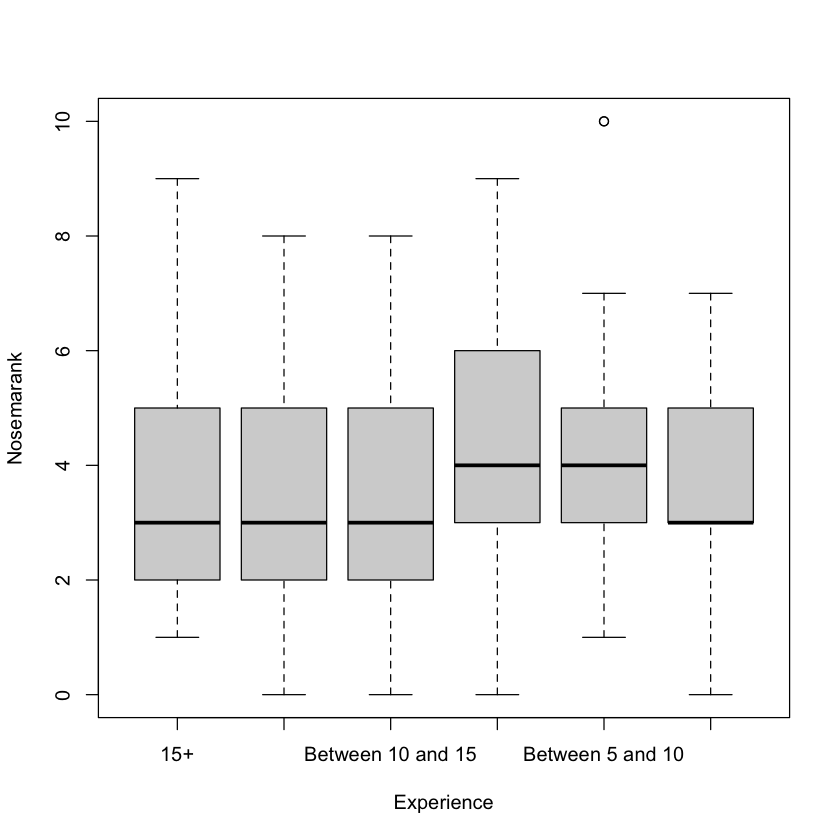

In [46]:
# create a data frame with just experience level and nosema rank for disease
ExpNos <- subset(survey_data, select = c(Experience, Pest_rank.Nosema))
colnames(ExpNos) <- c("Experience", "Nosemarank")
boxplot(Nosemarank ~ Experience, data = ExpNos)
# doesnt look like there is huge variation

In [47]:
kruskal.test(Nosemarank ~ Experience, data = ExpNos)
# non-signficant


	Kruskal-Wallis rank sum test

data:  Nosemarank by Experience
Kruskal-Wallis chi-squared = 4.1005, df = 5, p-value = 0.535



	Kruskal-Wallis rank sum test

data:  Nosemarank by Experience
Kruskal-Wallis chi-squared = 6.3979, df = 5, p-value = 0.2694


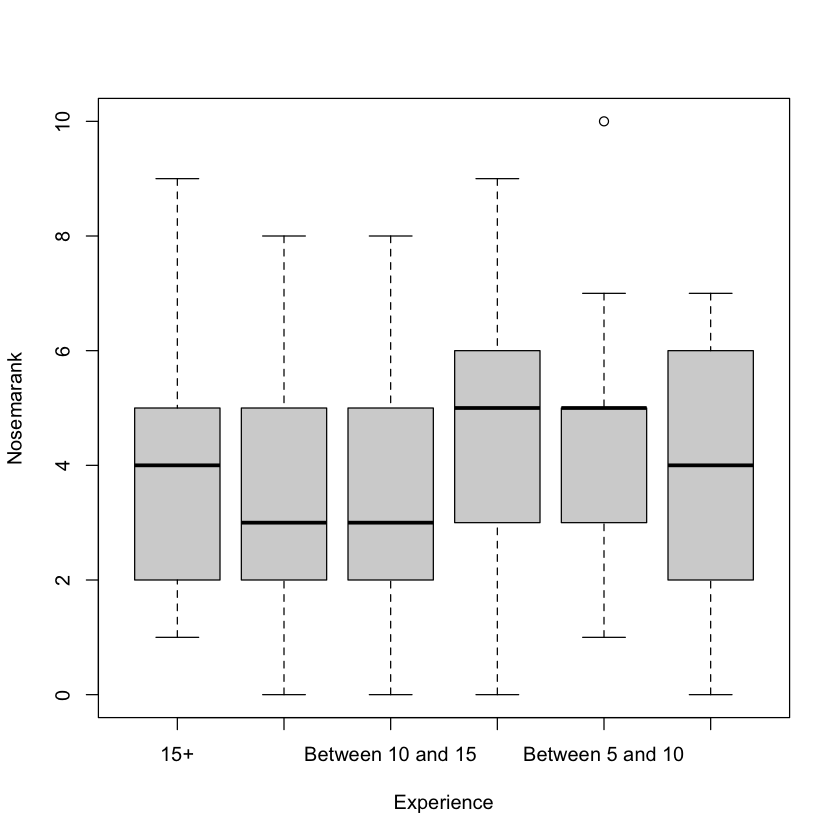

In [48]:
# UK
ExpNosUK <- subset(survey_data, select = c(Country, Experience, Pest_rank.Nosema))
ExpNosUK1 <-subset(ExpNosUK, Country=="UK")
colnames(ExpNosUK1) <- c("Country", "Experience", "Nosemarank")
boxplot(Nosemarank ~ Experience, data = ExpNosUK1)
# doesnt look like a major differrence
kruskal.test(Nosemarank ~ Experience, data = ExpNosUK1)
# non significant


	Kruskal-Wallis rank sum test

data:  Nosemarank by Experience
Kruskal-Wallis chi-squared = 4.6084, df = 5, p-value = 0.4655


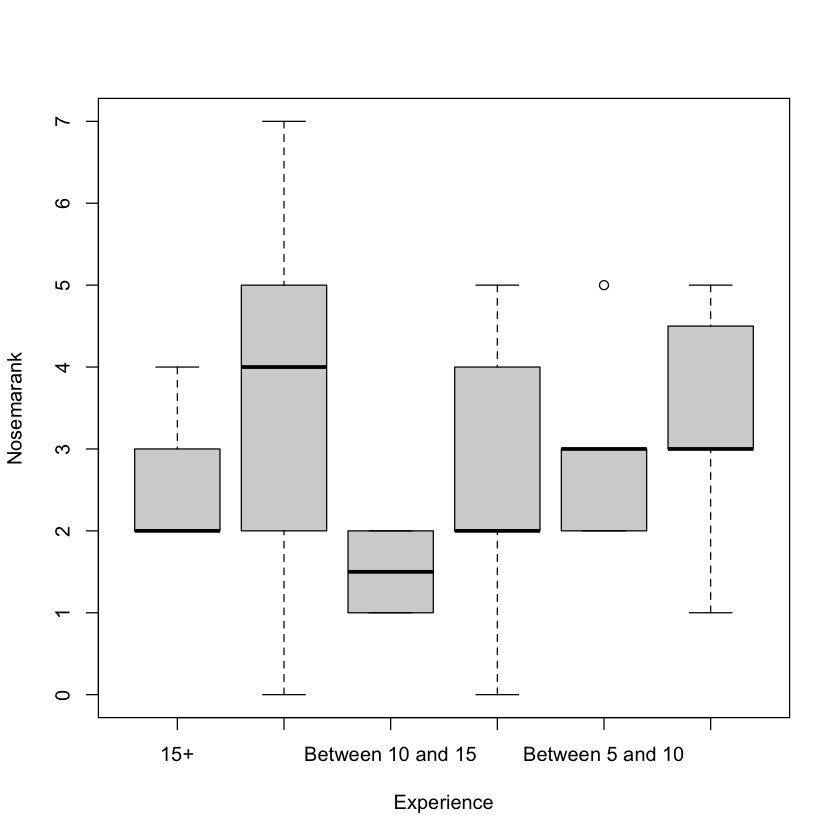

In [49]:
#US
ExpNosUS <- subset(survey_data, select = c(Country, Experience, Pest_rank.Nosema))
ExpNosUS1 <-subset(ExpNosUS, Country=="USA")
colnames(ExpNosUS1) <- c("Country", "Experience", "Nosemarank")
boxplot(Nosemarank ~ Experience, data = ExpNosUS1)
kruskal.test(Nosemarank ~ Experience, data = ExpNosUS1)
# non significant

Warning message:
“Removed 20 rows containing non-finite values (`stat_boxplot()`).”


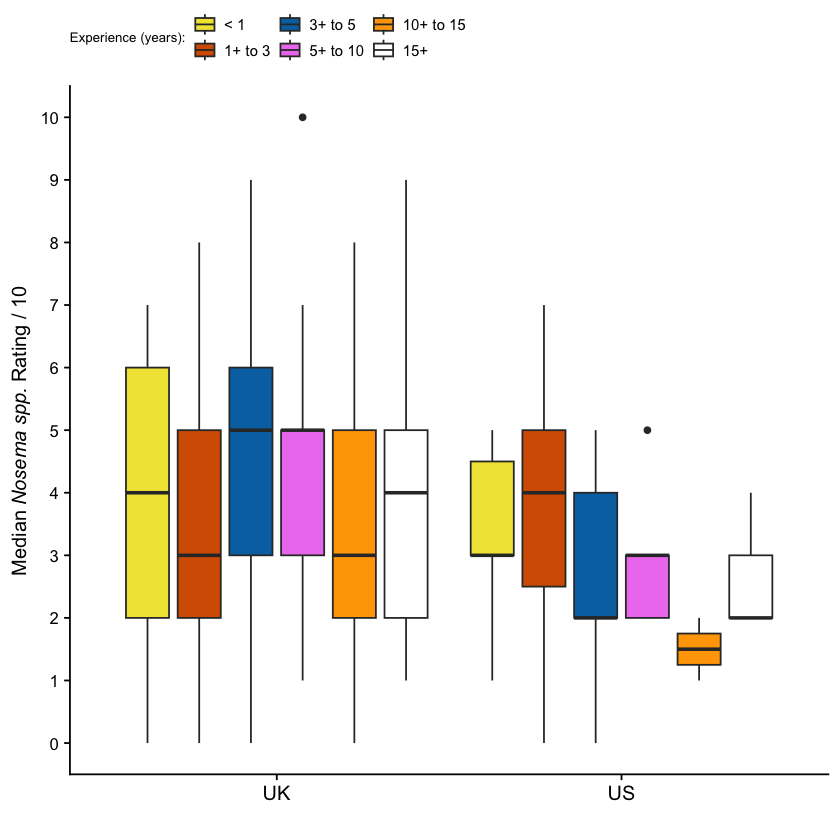

In [50]:
# PLotting this
ExperienceUSUK <- subset(surveyUSUK, select = c(Country, Experience, Pest_rank.Nosema))
colnames(ExperienceUSUK) <- c("Country", "Experience", "NosemaRating")
ExperienceUSUK$Experience <- factor(ExperienceUSUK$Experience,levels = c('Less than 1','Between 1 and 3', 'Between 3 and 5', 'Between 5 and 10', 'Between 10 and 15', '15+'),ordered = TRUE)
Experienceplot <- ggplot(data = ExperienceUSUK, aes(x = Country, y = NosemaRating, fill = Experience))
Experienceplot1 <- Experienceplot + geom_boxplot(aes(fill = Experience), position = position_dodge(0.9)) + theme_cowplot() + 
  theme(legend.position = "top") + ylab("Median"~italic("Nosema spp.")~"Rating / 10") + scale_x_discrete(labels = c("UK", "US")) + 
  theme(legend.text=element_text(size=9), legend.title=element_text(size=8)) + guides(fill=guide_legend(title="Experience (years):")) + xlab("") + theme(text = element_text(size=12), axis.text.y = element_text(size = 10)) + 
  scale_fill_manual(values=c("#F0E442", "#D55E00","#0072B2", "#EE82EE","#FFA500","#FFFFFF"), labels = c("< 1", "1+ to 3", "3+ to 5", "5+ to 10", "10+ to 15", "15+")) + scale_y_continuous(limits = c(0,10), breaks = seq(0,10, by = 1))
Experienceplot1

## 5. Does nosema rating vary with whether you have received any training? Or training on disease management?

In [51]:
TrainNos <- subset(survey_data, select = c(Training, Pest_rank.Nosema))
colnames(TrainNos) <- c("Training", "Nosemarank")

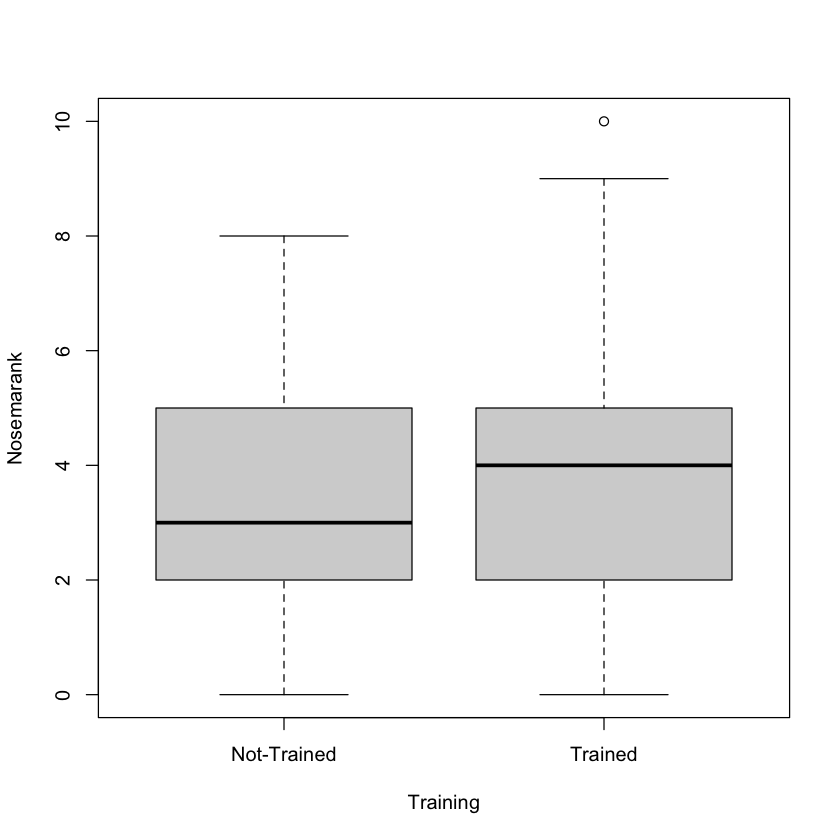

In [52]:
# somehow, some respondants put "I haven't used education programmes", and then proceeded to select other options.
# i will remove these rows from the analysis
TrainNos1 <- TrainNos[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]
TrainNos1$Training <- ifelse(TrainNos1$Training == "I haven't used educational programmes","Not-Trained","Trained") 
boxplot(Nosemarank ~ Training, data = TrainNos1)

In [53]:
# lets have a look at a difference between the two groups
wilcox.test(Nosemarank ~ Training, data = TrainNos1, alt="two.sided", conf.level = 0.95)


	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Training
W = 6502.5, p-value = 0.3542
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Training
W = 4350.5, p-value = 0.5095
alternative hypothesis: true location shift is not equal to 0


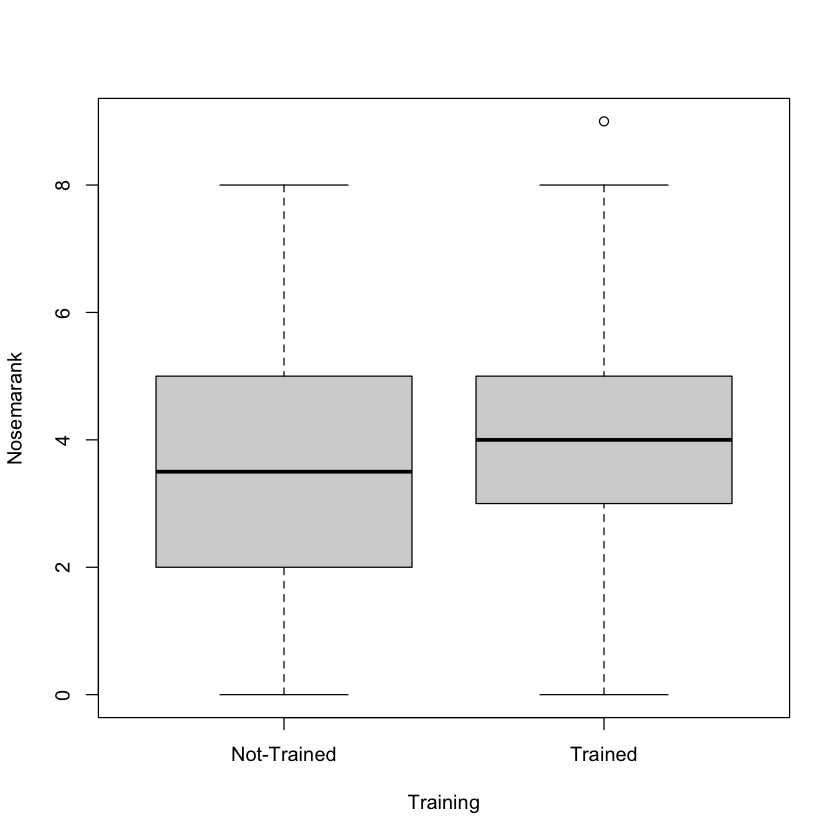

In [54]:
# split these into UK and US
#UK
TrainNosUK <- subset(survey_data, select = c(Country, Training, Pest_rank.Nosema))
colnames(TrainNosUK) <- c("Country", "Training", "Nosemarank")
TrainNosUK <- TrainNosUK[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]
TrainNosUK$Training <- ifelse(TrainNosUK$Training == "I haven't used educational programmes","Not-Trained","Trained")
TrainNosUK <- subset(TrainNosUK, Country == "UK")
boxplot(Nosemarank ~ Training, data = TrainNosUK)
# doesnt look like much difference
wilcox.test(Nosemarank ~ Training, data = TrainNosUK, alt="two.sided", conf.level = 0.95, na.action = na.omit)

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Training
W = 100, p-value = 0.7852
alternative hypothesis: true location shift is not equal to 0


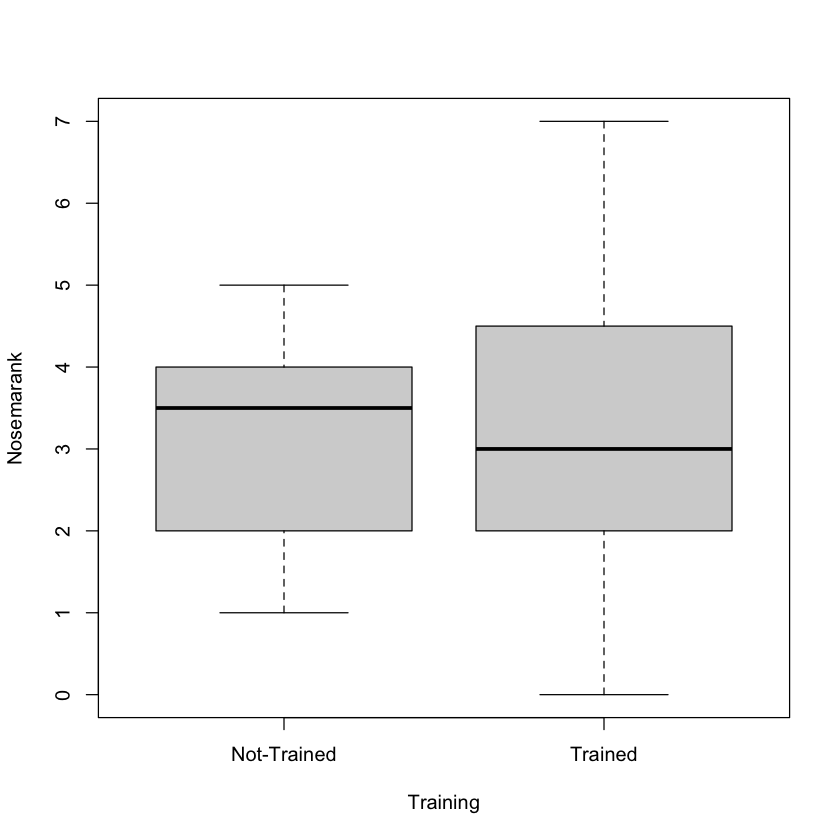

In [55]:
#US
TrainNosUS <- subset(survey_data, select = c(Country, Training, Pest_rank.Nosema))
colnames(TrainNosUS) <- c("Country", "Training", "Nosemarank")
TrainNosUS <- TrainNosUS[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]
TrainNosUS$Training <- ifelse(TrainNosUS$Training == "I haven't used educational programmes","Not-Trained","Trained")
TrainNosUS <- subset(TrainNosUS, Country == "USA")
boxplot(Nosemarank ~ Training, data = TrainNosUS)
# again, doesnt look like a massive difference
wilcox.test(Nosemarank ~ Training, data = TrainNosUS, alt="two.sided", conf.level = 0.95, na.action = na.omit)

In [56]:
# what about those had recieved training specifically on disease management?
diseasetrainNos <- subset(survey_data, select = c(Training, Pest_rank.Nosema))
colnames(diseasetrainNos) <- c("Training", "Nosemarank")
# again, remove the people who somehow entered two conflicting answers
diseasetrainNos1 <- diseasetrainNos[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]

In [57]:
# i want to compare between those who had disease training and those who didnt have disease training 
# but training in other areas so still remove all non-trained people
trainingonly <- filter(diseasetrainNos1, !grepl("I haven't used educational programmes", Training))
# these are all the people who have definitely received training
# now need to sort between those that have received disease training (whether alone or with other topics), and those who have not
trainingonly$Training <- ifelse(grepl("Disease",trainingonly$Training),'disease trained','not disease trained')

# change name no confusion
diseasetrained <- trainingonly


	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Training
W = 6514.5, p-value = 0.9913
alternative hypothesis: true location shift is not equal to 0


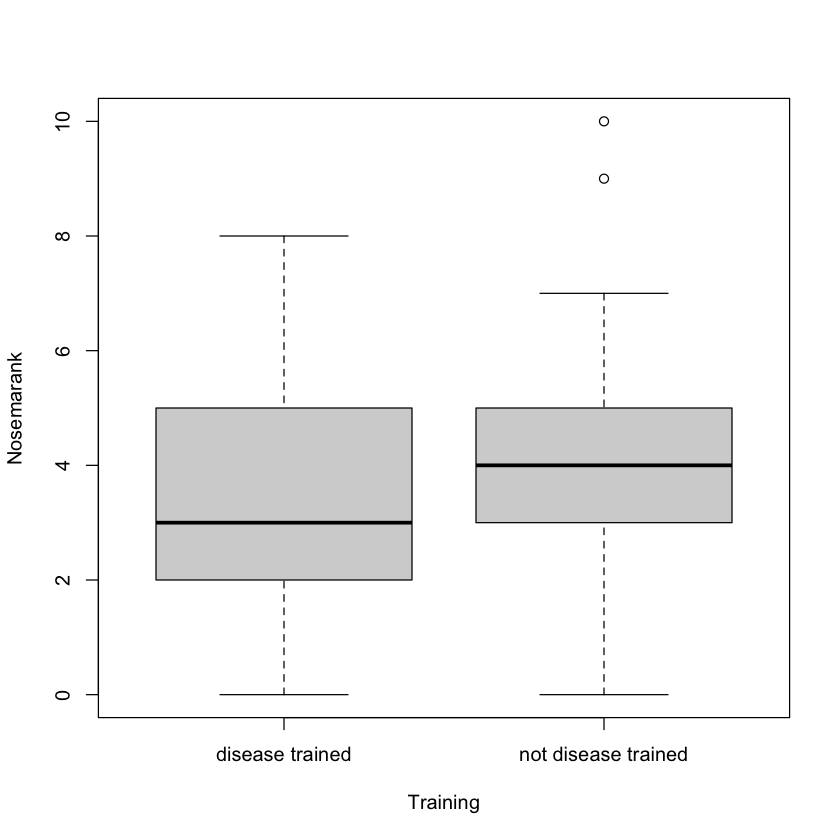

In [58]:
boxplot(Nosemarank ~ Training, data = diseasetrained)
# if anything, those with disease training are lower than those who are not
# lets test
wilcox.test(Nosemarank ~ Training, data = diseasetrained, alt="two.sided", conf.level = 0.95, na.action = na.omit)
# non significant


	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Training
W = 4108.5, p-value = 0.9589
alternative hypothesis: true location shift is not equal to 0


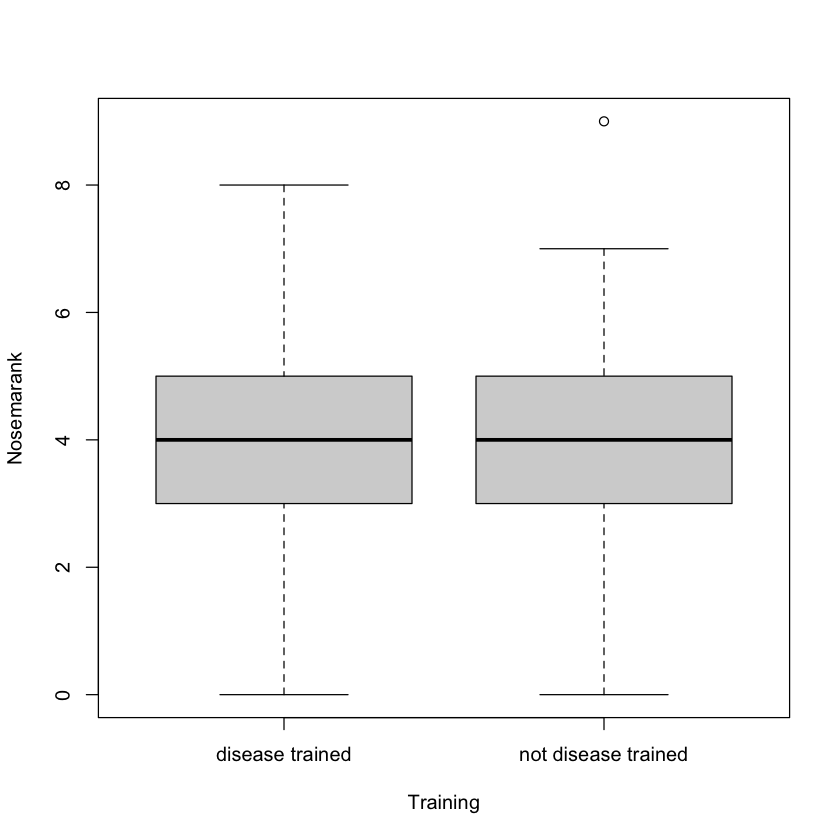

In [61]:
# UK
diseasetrainNosUK <- subset(survey_data, select = c(Country, Training, Pest_rank.Nosema))
colnames(diseasetrainNosUK) <- c("Country", "Training", "Nosemarank")
diseasetrainNosUK <- diseasetrainNosUK[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]
trainingonlyUK <- filter(diseasetrainNosUK, !grepl("I haven't used educational programmes", Training))
trainingonlyUK$Training <- ifelse(grepl("Disease",trainingonlyUK$Training),'disease trained','not disease trained')
trainingonlyUK <- subset(trainingonlyUK, Country == "UK")
boxplot(Nosemarank ~ Training, data = trainingonlyUK)
wilcox.test(Nosemarank ~ Training, data = trainingonlyUK, alt="two.sided", conf.level = 0.95, na.action = na.omit)

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Training
W = 113, p-value = 0.5495
alternative hypothesis: true location shift is not equal to 0


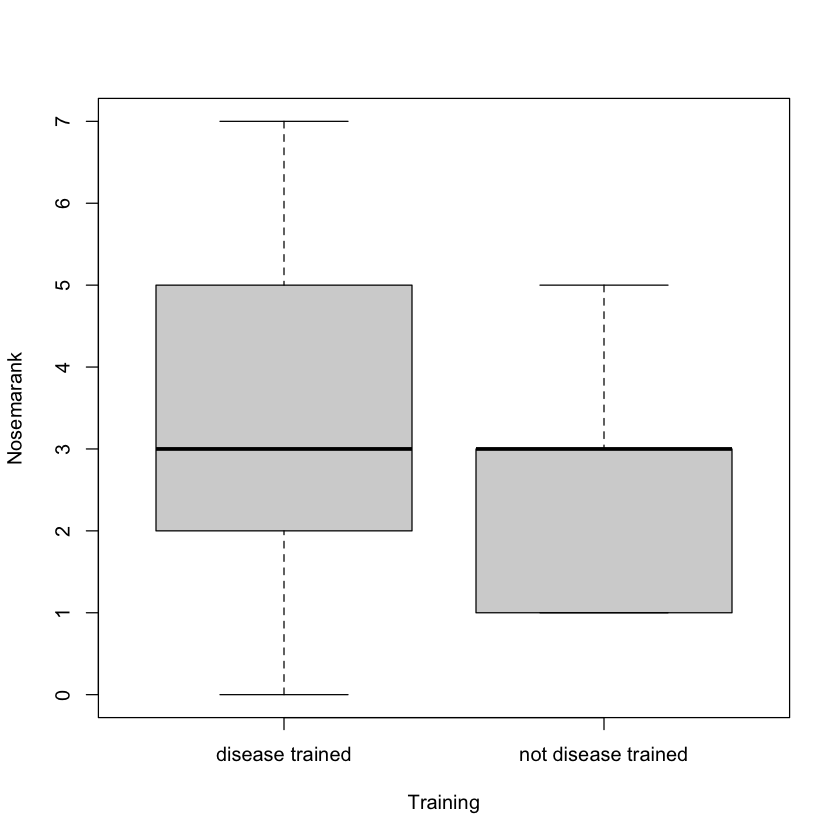

In [62]:
# US
diseasetrainNosUS <- subset(survey_data, select = c(Country, Training, Pest_rank.Nosema))
colnames(diseasetrainNosUS) <- c("Country", "Training", "Nosemarank")
diseasetrainNosUS <- diseasetrainNosUS[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]
trainingonlyUS <- filter(diseasetrainNosUS, !grepl("I haven't used educational programmes", Training))
trainingonlyUS$Training <- ifelse(grepl("Disease",trainingonlyUS$Training),'disease trained','not disease trained')
trainingonlyUS <- subset(trainingonlyUS, Country == "USA")
boxplot(Nosemarank ~ Training, data = trainingonlyUS)
wilcox.test(Nosemarank ~ Training, data = trainingonlyUS, alt="two.sided", conf.level = 0.95, na.action = na.omit)


	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Training
W = 7474.5, p-value = 0.659
alternative hypothesis: true location shift is not equal to 0


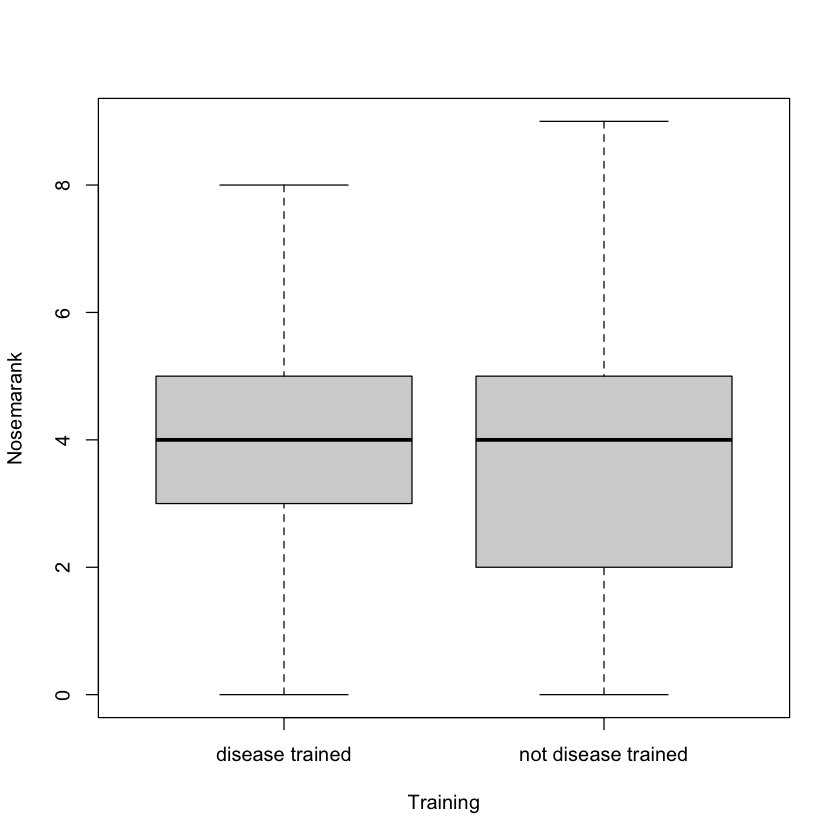

In [64]:
# UK comparison for those who had received disease management training in last 5 years compared to those who havent
diseasetrainNosUK <- subset(survey_data, select = c(Country, Training, Pest_rank.Nosema))
colnames(diseasetrainNosUK) <- c("Country", "Training", "Nosemarank")
diseasetrainNosUK <- diseasetrainNosUK[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]
diseasetrainNosUK <- subset(diseasetrainNosUK, Country == "UK")
diseasetrainNosUK$Training <- ifelse(grepl("Disease",diseasetrainNosUK$Training),'disease trained','not disease trained')
boxplot(Nosemarank ~ Training, data = diseasetrainNosUK)
wilcox.test(Nosemarank ~ Training, data = diseasetrainNosUK, alt="two.sided", conf.level = 0.95, na.action = na.omit)

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Training
W = 177.5, p-value = 0.7057
alternative hypothesis: true location shift is not equal to 0


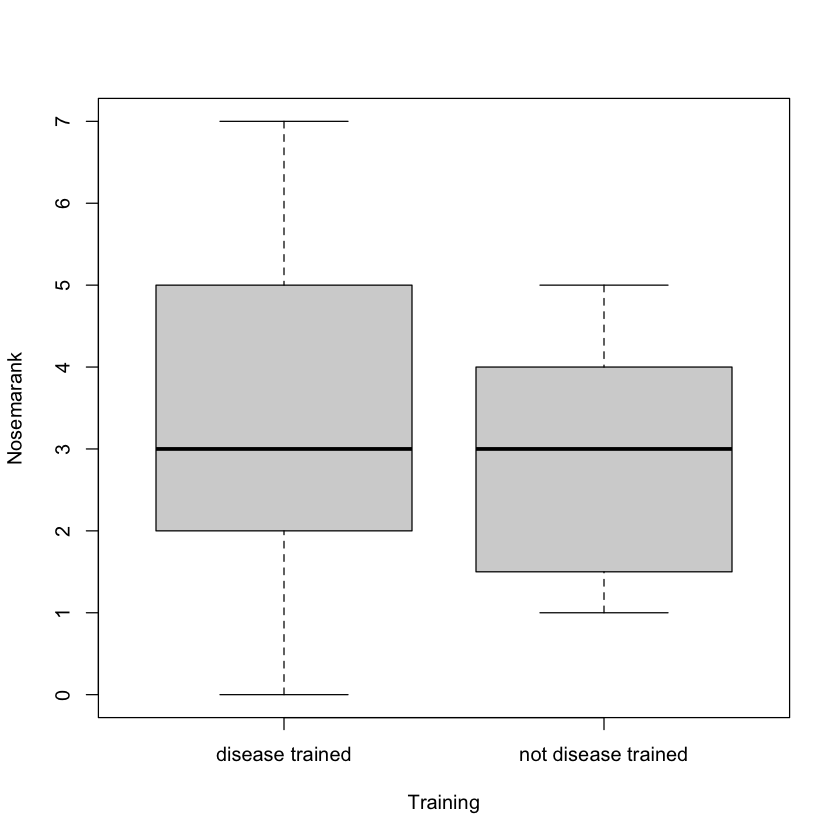

In [65]:
# US
diseasetrainNosUS <- subset(survey_data, select = c(Country, Training, Pest_rank.Nosema))
colnames(diseasetrainNosUS) <- c("Country", "Training", "Nosemarank")
diseasetrainNosUS <- diseasetrainNosUS[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]
diseasetrainNosUS <- subset(diseasetrainNosUS, Country == "USA")
diseasetrainNosUS$Training <- ifelse(grepl("Disease",diseasetrainNosUS$Training),'disease trained','not disease trained')
boxplot(Nosemarank ~ Training, data = diseasetrainNosUS)
wilcox.test(Nosemarank ~ Training, data = diseasetrainNosUS, alt="two.sided", conf.level = 0.95, na.action = na.omit)

Warning message:
“Removed 19 rows containing non-finite values (`stat_boxplot()`).”


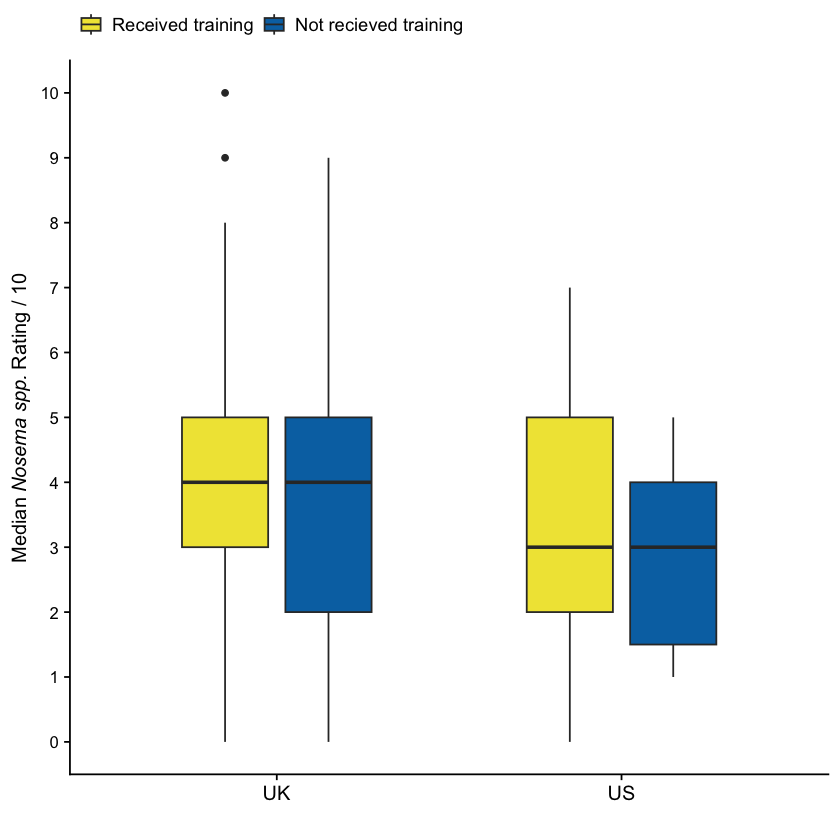

In [67]:
diseasetrainNosUSUK <- subset(surveyUSUK, select = c(Country, Training, Pest_rank.Nosema))
colnames(diseasetrainNosUSUK) <- c("Country", "Training", "NosemaRating")
diseasetrainNosUSUK <- diseasetrainNosUSUK[-c(69, 92, 100, 150, 170, 175, 218, 281, 327), ]
diseasetrainNosUSUK$Training <- ifelse(grepl("Disease",diseasetrainNosUSUK$Training),'disease trained','not disease trained')
diseasetrainNosUSUK$Training <- factor(diseasetrainNosUSUK$Training,levels = c('disease trained', 'not disease trained'),ordered = TRUE)
Trainingplot <- ggplot(data = diseasetrainNosUSUK, aes(x = Country, y = NosemaRating, fill = Training))
Trainingplot1 <- Trainingplot + geom_boxplot(aes(fill = Training), position = position_dodge(0.6), width = 0.5) + theme_cowplot() + 
  theme(legend.position = "top") + ylab("Median"~italic("Nosema spp.")~"Rating / 10") + scale_x_discrete(labels = c("UK", "US")) + 
  theme(legend.text=element_text(size=11), legend.title=element_text(size=10)) + guides(fill=guide_legend(title="")) + xlab("") + theme(text = element_text(size=12), axis.text.y = element_text(size = 10)) + 
  scale_fill_manual(values=c("#F0E442", "#0072B2"), labels = c("Received training", "Not recieved training")) + scale_y_continuous(limits = c(0,10), breaks = seq(0,10, by = 1))
Trainingplot1

## 6. Do keepers who supplement pollen consider nosema bigger threat?


	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Pollen
W = 9710, p-value = 0.3493
alternative hypothesis: true location shift is not equal to 0


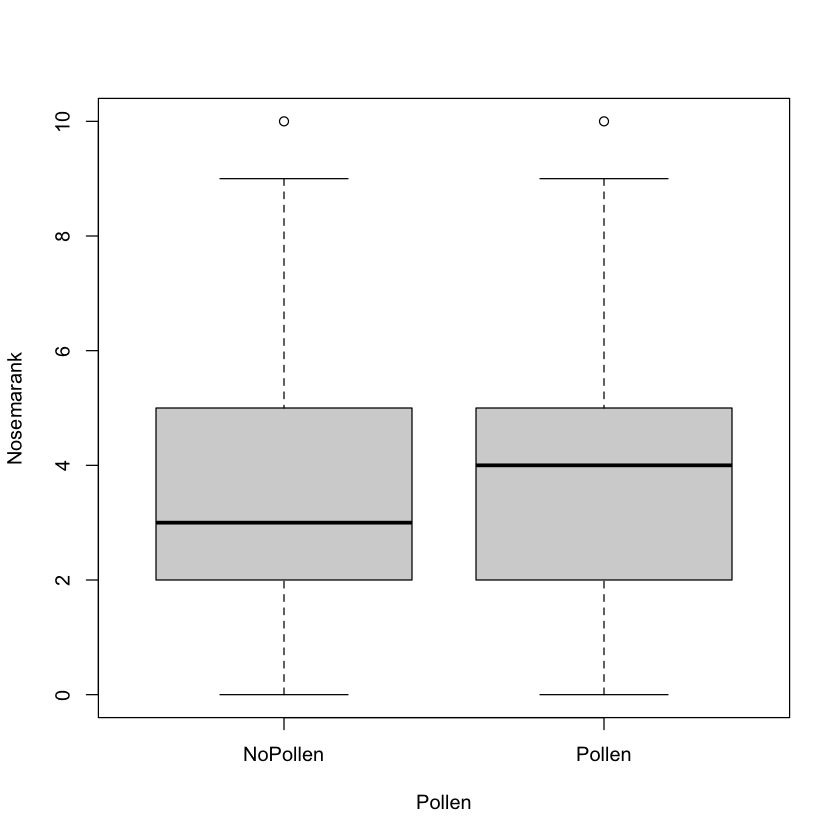

In [69]:
PollenNos <- subset(survey_data, select = c(If.WhenPollen, Pest_rank.Nosema))
colnames(PollenNos) <- c("Pollen", "Nosemarank")
# do those who supplement pollen consider nosema a bigger threat?
PollenNos$Pollen <- ifelse(PollenNos$Pollen == "I don't supplement pollen", "NoPollen", "Pollen")
boxplot(Nosemarank ~ Pollen, data = PollenNos)
wilcox.test(Nosemarank ~ Pollen, data = PollenNos, alt="two.sided", conf.level = 0.95, na.action = na.omit)
# those who supplement pollen do not consider nosema any greater a threat


	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Pollen
W = 5802.5, p-value = 0.1896
alternative hypothesis: true location shift is not equal to 0


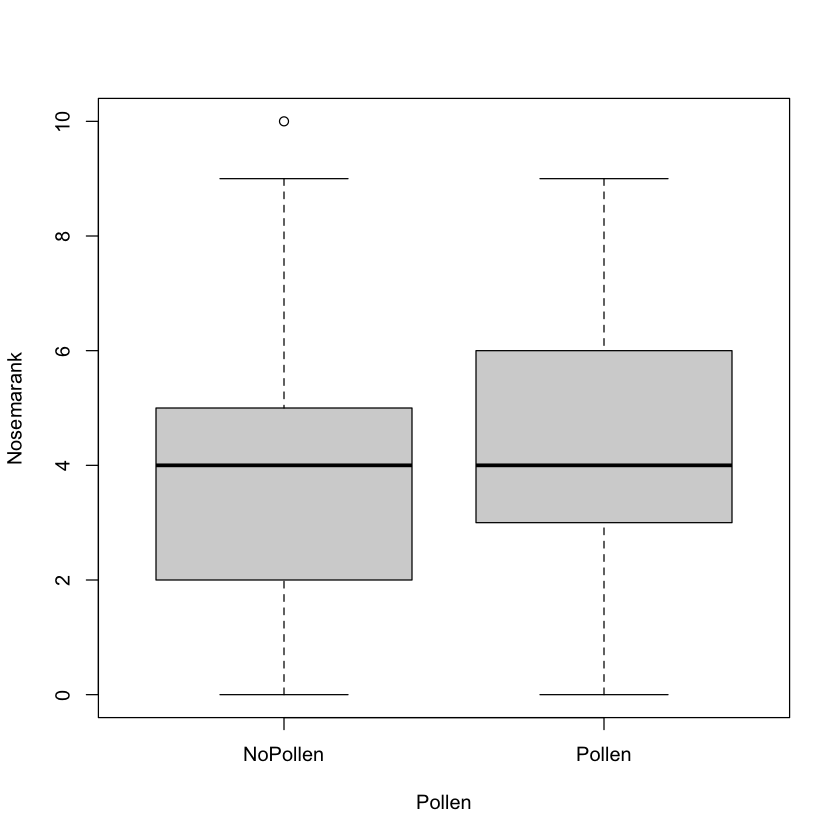

In [71]:
#UK
PollenNosUK <- subset(survey_data, select = c(Country, If.WhenPollen, Pest_rank.Nosema))
colnames(PollenNosUK) <- c("Country", "Pollen", "Nosemarank")
PollenNosUK$Pollen <- ifelse(PollenNosUK$Pollen == "I don't supplement pollen", "NoPollen", "Pollen")
PollenNosUK <- subset(PollenNosUK, Country == "UK")
boxplot(Nosemarank ~ Pollen, data = PollenNosUK)
wilcox.test(Nosemarank ~ Pollen, data = PollenNosUK, alt="two.sided", conf.level = 0.95, na.action = na.omit)

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Pollen
W = 185, p-value = 0.8937
alternative hypothesis: true location shift is not equal to 0


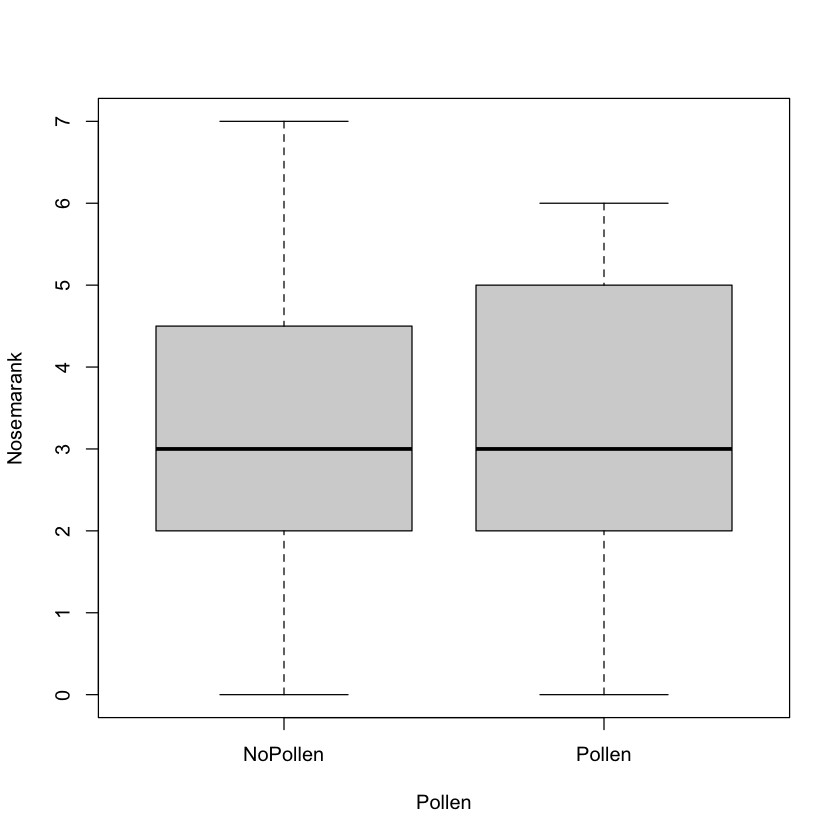

In [72]:
#US
PollenNosUS <- subset(survey_data, select = c(Country, If.WhenPollen, Pest_rank.Nosema))
colnames(PollenNosUS) <- c("Country", "Pollen", "Nosemarank")
PollenNosUS$Pollen <- ifelse(PollenNosUS$Pollen == "I don't supplement pollen", "NoPollen", "Pollen")
PollenNosUS <- subset(PollenNosUS, Country == "USA")
boxplot(Nosemarank ~ Pollen, data = PollenNosUS)
wilcox.test(Nosemarank ~ Pollen, data = PollenNosUS, alt="two.sided", conf.level = 0.95, na.action = na.omit)

Warning message:
“Removed 20 rows containing non-finite values (`stat_boxplot()`).”


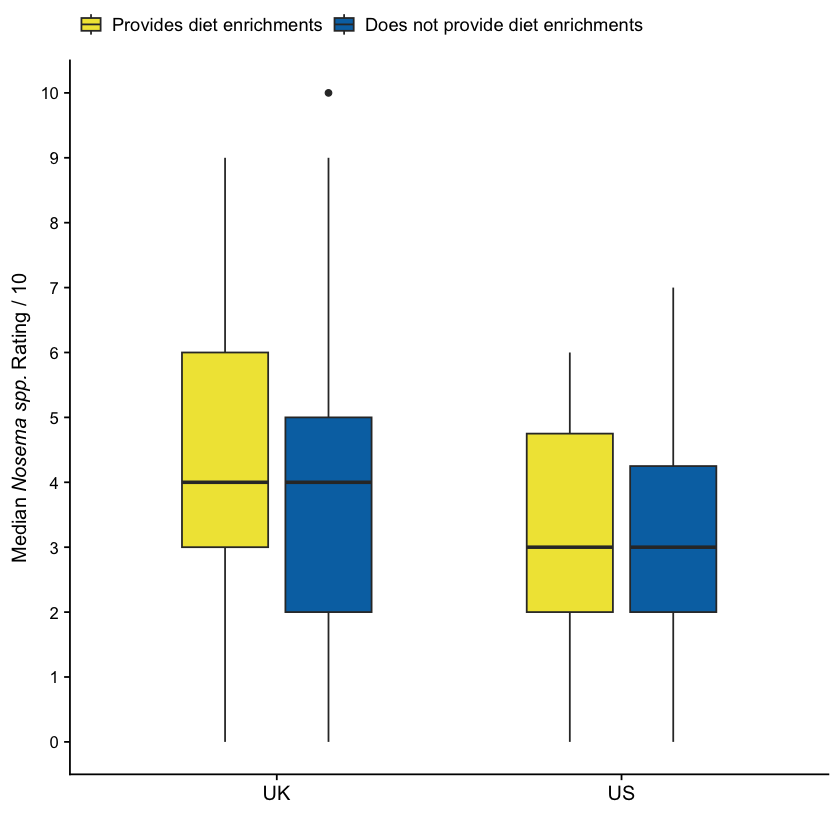

In [73]:
# lets plot this
PollenNosUSUK <- subset(surveyUSUK, select = c(Country, If.WhenPollen, Pest_rank.Nosema))
colnames(PollenNosUSUK) <- c("Country", "Pollen", "NosemaRating")
PollenNosUSUK$Pollen <- ifelse(PollenNosUSUK$Pollen == "I don't supplement pollen", "NoPollen", "Pollen")
PollenNosUSUK$Pollen <- factor(PollenNosUSUK$Pollen,levels = c('Pollen', 'NoPollen'),ordered = TRUE)
Enrichmentplot <- ggplot(data = PollenNosUSUK, aes(x = Country, y = NosemaRating, fill = Pollen))
Enrichmentplot1 <- Enrichmentplot + geom_boxplot(aes(fill = Pollen), position = position_dodge(0.6), width = 0.5) + theme_cowplot() + 
  theme(legend.position = "top") + ylab("Median"~italic("Nosema spp.")~"Rating / 10") + scale_x_discrete(labels = c("UK", "US")) + 
  theme(legend.text=element_text(size=11), legend.title=element_text(size=10)) + guides(fill=guide_legend(title="")) + xlab("") + theme(text = element_text(size=12), axis.text.y = element_text(size = 10)) + 
  scale_fill_manual(values=c("#F0E442", "#0072B2"), labels = c("Provides diet enrichments", "Does not provide diet enrichments")) + scale_y_continuous(limits = c(0,10), breaks = seq(0,10, by = 1))
Enrichmentplot1

In [76]:
# does it matter when keepers supplement pollen?
# remove everyone who doesnt supplement
PollenNos <- subset(survey_data, select = c(If.WhenPollen, Pest_rank.Nosema))
colnames(PollenNos) <- c("Pollen", "Nosemarank")
Pollsupplementers <- filter(PollenNos, !grepl("I don't supplement pollen", Pollen))
Pollsupplementers$Pollen <- ifelse(grepl("Spring",Pollsupplementers$Pollen),'Spring Suppers','Non-spring suppers')
wilcox.test(Nosemarank ~ Pollen, data = Pollsupplementers, alt="two.sided", conf.level = 0.95, na.action = na.omit)


	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Pollen
W = 889.5, p-value = 0.9933
alternative hypothesis: true location shift is not equal to 0


In [78]:
# what about people who supplement in winter
PollenNos <- subset(survey_data, select = c(If.WhenPollen, Pest_rank.Nosema))
colnames(PollenNos) <- c("Pollen", "Nosemarank")
Pollsupplementers <- filter(PollenNos, !grepl("I don't supplement pollen", Pollen))
Pollsupplementers$Pollen <- ifelse(grepl("Winter",Pollsupplementers$Pollen),'Winter Suppers','Non-winter suppers')
wilcox.test(Nosemarank ~ Pollen, data = Pollsupplementers, alt="two.sided", conf.level = 0.95, na.action = na.omit)


	Wilcoxon rank sum test with continuity correction

data:  Nosemarank by Pollen
W = 964.5, p-value = 0.8194
alternative hypothesis: true location shift is not equal to 0
